<a href="https://colab.research.google.com/github/AbhishekMohanty05/AbhishekMohanty01/blob/main/BIKE_SENTIMENT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-10-caaca7fa1d02>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['review_description'].fillna('', inplace=True)  # Replace null strings with an empty string
<ipython-input-10-caaca7fa1d02>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

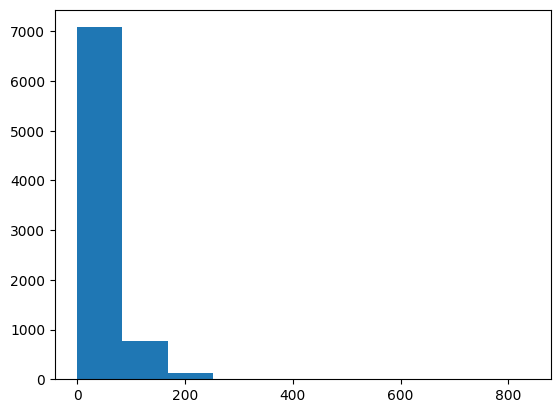

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 20

Training Loss: 0.5005368662731988
Validation Loss: 0.3291325490725668

 Epoch 2 / 20

Training Loss: 0.28157143958977293
Validation Loss: 0.27782436028907176

 Epoch 3 / 20

Training Loss: 0.19558065263288363
Validation Loss: 0.21199389101055108

 Epoch 4 / 20

Training Loss: 0.12045260324542012
Validation Loss: 0.2087827538336186

 Epoch 5 / 20

Training Loss: 0.07540114404899734
Validation Loss: 0.22441889710822388

 Epoch 6 / 20

Training Loss: 0.046761112364807296
Validation Loss: 0.21685496376410715

 Epoch 7 / 20

Training Loss: 0.02404975540802947
Validation Loss: 0.20275305710904495

 Epoch 8 / 20

Training Loss: 0.016418407391424156
Validation Loss: 0.20240732301087855

 Epoch 9 / 20

Training Loss: 0.011751963909316276
Validation Loss: 0.20976150938459845

 Epoch 10 / 20

Training Loss: 0.010402993475519387
Validation Loss: 0.23585157766616535

 Epoch 11 / 20

Training Loss: 0.01316359825789862
Validation Loss: 0.2564574230656083

 Epoch 12 / 20

Training Loss

<ipython-input-10-caaca7fa1d02>:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_weights.pt'))


              precision    recall  f1-score   support

           0       0.94      0.99      0.96       600
           1       0.99      0.94      0.96       600

    accuracy                           0.96      1200
   macro avg       0.97      0.96      0.96      1200
weighted avg       0.97      0.96      0.96      1200



In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample, class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/Bike_Reviews_Final_1.csv', encoding='Windows-1252') # or 'latin-1', 'ISO-8859-1'

# Check for null values and handle them
df['review_description'].fillna('', inplace=True)  # Replace null strings with an empty string
df['label'].fillna(-1, inplace=True)  # Replace null labels with -1 (to be dropped later)

# Ensure correct datatypes
df['review_description'] = df['review_description'].astype(str)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(-1).astype(int)

# Drop rows with invalid labels (-1)
df = df[df['label'] != -1]

# Balance the dataset to have 4000 samples for each class
df_positive = df[df['label'] == 1].sample(n=4000, random_state=42)  # Downsample positive to 4000
df_negative = resample(df[df['label'] == 0], replace=True, n_samples=4000, random_state=42)  # Oversample negative to 4000
df = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# Basic statistics for text lengths
lens = [len(i.split()) for i in df['review_description']]
plt.hist(lens)
plt.show()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['review_description'], df['label'],
                                                                    random_state=2021, test_size=0.3,
                                                                    stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021, test_size=0.5,
                                                                stratify=temp_labels)

# Load BERT model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Define padding length based on text lengths
pad_len = 17

# Tokenize and encode sequences
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)
tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)

# Convert tokens to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Define dataloaders
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Define the BERT-based model architecture
class BERT_architecture(nn.Module):
    def __init__(self, bert):
        super(BERT_architecture, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate and move model to device
model = BERT_architecture(bert)
model = model.to(device)

# Optimizer and weighted loss function
optimizer = transformers.AdamW(model.parameters(), lr=1e-5)
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
cross_entropy = nn.NLLLoss(weight=weights)

# Training and evaluation functions
def train():
    model.train()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(train_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

def evaluate():
    model.eval()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(val_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# Train and evaluate the model
epochs = 20
best_valid_loss = float('inf')
train_losses, valid_losses = [], []

for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')
    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss}')
    print(f'Validation Loss: {valid_loss}')

# Load best model weights
model.load_state_dict(torch.load('saved_weights.pt'))

# Test the model
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

pred = np.argmax(preds, axis=1)
print(classification_report(test_y, pred))
